# Loading Packages

In [1]:
import os
import operator
import sys
sys.path.insert(-1, os.path.abspath('../code/'))

In [2]:
import numpy as np
import scipy.ndimage
import scipy.misc
import torch
import torchvision
from analyze import ApproximateAccuracy_API, Line, _get_accuracies_at_radii
from architectures import get_architecture

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Make sure you install the API-related package google-cloud-vision, boto3, clarifai first.
from robust_api import RobustAPI

# Loading Denoisers

In [4]:
weight_path="../pretrained_models/trained_denoisers/imagenet/mse_obj/dncnn_5epoch_lr1e-4/noise_0.12/best.pth.tar"

checkpoint = torch.load(weight_path)
denoiser = get_architecture(checkpoint['arch'] , 'imagenet')
denoiser.load_state_dict(checkpoint['state_dict'])
print('Successfully loaded the denoiser!')

Successfully loaded the denoiser!


# Displaying Images

In [5]:
IMG_PATH= ["images/ILSVRC2012_val_00000018.png", "images/ILSVRC2012_val_00016711.png", 
           "images/ILSVRC2012_val_00025384.png"]

img_list = []
for path in IMG_PATH:
    img_list.append(plt.imread(path))
    
def show_img_row(img_list):
    fig=plt.figure(figsize=(14, 18))
    fig.add_subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(img_list[0])
    fig.add_subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(img_list[1])
    fig.add_subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(img_list[2])
    plt.show()

### Clean Image

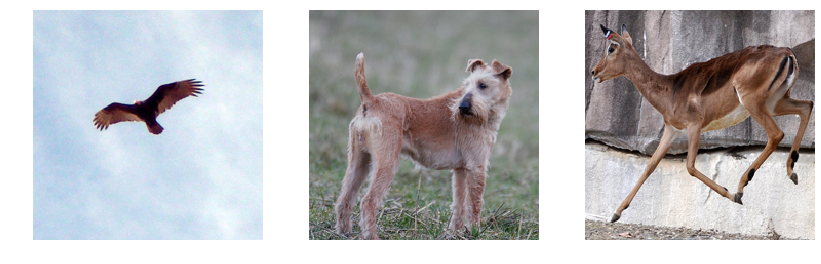

In [6]:
show_img_row(img_list)

### Noisy Image

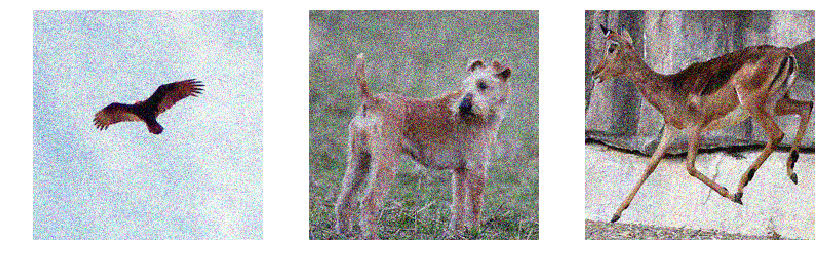

In [7]:
noisy_img_list = []

for img in img_list:
    noisy_img_list.append(np.clip(img + np.random.randn(*img.shape) * 0.12, 0, 1))

show_img_row(noisy_img_list)

### Denoised Image

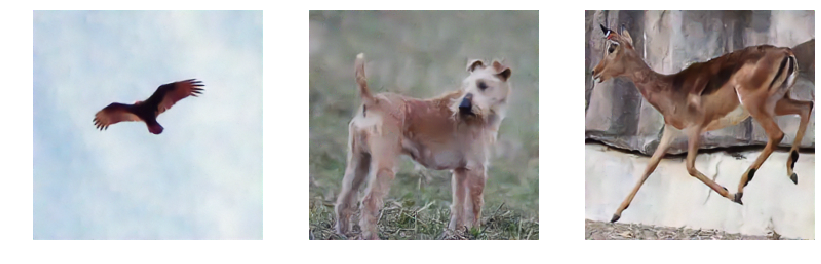

In [8]:
out_list = []
for noisy_img in noisy_img_list:
    img_tmp = np.transpose(noisy_img, (2,0,1))
    img_tmp = np.expand_dims(img_tmp,0)
    img_tmp = torch.Tensor(img_tmp).cuda()
    
    denoiser.eval()
    with torch.no_grad():
        out = torch.clamp(denoiser(img_tmp), 0, 1)
    
    out_list.append(np.transpose(out[0].cpu().numpy(), (1,2,0)))

show_img_row(out_list)

## Certify Vision API

### Setup Credentials

1. Azure Vision API:
Follow [this link](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account?tabs=singleservice%2Cunix) and obtain the keys for your Azure Cognitive Services. Then create environment variables for the API key `AZURE_COMPUTER_VISION_SUBSCRIPTION_KEY` and the endpoint URL `AZURE_COMPUTER_VISION_ENDPOINT`.
2. Google Computer Vision API:
Follow the instructions on [this link](https://cloud.google.com/vision/docs/before-you-begin). In the end, you should set the environment variable `GOOGLE_APPLICATION_CREDENTIALS` to the path of the JSON file where your service account key is stored.
3. Clarifai API:
Authentication to the API is handled through API Keys. Obtain the Clarifai API access key set the environment variable `CLARIFAI_API_KEY`.
4. AWS Recoknition API:
Follow the two instructions in Step 1 in [this link](https://docs.aws.amazon.com/rekognition/latest/dg/labels-detect-labels-image.html#w696aac25c19b7b6b3b5). In the end, you should set two variables `aws_access_key_id` and `aws_secret_access_key` in the `~/.aws/config` file.

In [ ]:
# You can set the environment variable for credentials here. Just put it as it is. No need to put it in a string :)

# Azure API credentials
%env AZURE_COMPUTER_VISION_SUBSCRIPTION_KEY=<AZURE API KEY>
%env AZURE_COMPUTER_VISION_ENDPOINT=<AZURE ENDPOINT>
    
# Google API credentials
%env GOOGLE_APPLICATION_CREDENTIALS=<GOOGLE API KEY>
# Clarifai API credentials
%env CLARIFAI_API_KEY=<CLARIFAI API KEY>

### Install API-Related Dependencies

In [10]:
# Comment this line if you haven't installed these packages
# !pip install google-cloud-vision boto3 clarifai

### Azure API

In [11]:
online_robust_api_base = RobustAPI("azure", online=True)
true_class, top_class_distribution, logs = online_robust_api_base.predict(img_list[0], N=1, noise_sd=0)

print("Predicted results by Azure API:")
for item in logs[0]:
    print("%20s : %f"%(item['name'], item['confidence']))
print("\n")
print("The top label is: \'%s\'"%true_class)
print("The top class distribution of the N samples is: {}".format(top_class_distribution))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
Predicted results by Azure API:
              animal : 0.999091
             outdoor : 0.998624
                bird : 0.997051
              flying : 0.964827
               eagle : 0.906338
        bird of prey : 0.875602
              falcon : 0.804441
              flight : 0.737210
              cloudy : 0.722062
             vulture : 0.671532
                blue : 0.593966
                 day : 0.361182


The top label is: 'animal'
The top class distribution of the N samples is: defaultdict(<class 'int'>, {'animal': 1})


#### Now let's try to certify using this API. The output of certify is 
- top_class: the majority vote class over 20 samples
- radius: the certified L2 radius around this datapoint
- logs: a list of query logs for each of the 120 samples used in certification (to save locally for optionally later use) 

In [12]:
online_robust_api_denoiser = RobustAPI("azure", denoiser=denoiser, online=True)
top_class, radius, logs = online_robust_api_denoiser.certify(img_list[0], noise_sd=0.12, N0=20, N=100, alpha=0.001)

if top_class == -1:
    print("Certification abstained!")
elif top_class == true_class:
    print("Certification Succeed!")
    print("Top label %s is correct with certified radius %f\n"%(top_class, radius))
else:
    print("Certification failed!"%(true_class, top_class, pred))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
pA: 0.933
Certification Succeed!
Top label animal is correct with certified radius 0.180057



### Google API

In [13]:
online_robust_api_base = RobustAPI("google", online=True)
true_class, top_class_distribution, logs = online_robust_api_base.predict(img_list[0], N=1, noise_sd=0)

print("Predicted results by Google API:")
for key in logs[0]:
    print("%20s: %f"%(key,logs[0][key]))
print("\n")
print("The top label is: \'%s\'"%true_class)
print("The top class distribution of the N samples is: {}".format(top_class_distribution))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
Predicted results by Google API:
                Bird: 0.988264
        Bird of prey: 0.964241
               Eagle: 0.956239
      Turkey Vulture: 0.953948
     Accipitriformes: 0.927066
        Accipitridae: 0.884204
             Buzzard: 0.863424
                Kite: 0.835483
        Golden eagle: 0.826144
                Beak: 0.815635


The top label is: 'Bird'
The top class distribution of the N samples is: defaultdict(<class 'int'>, {'Bird': 1})


In [14]:
online_robust_api_denoiser = RobustAPI("google", denoiser=denoiser, online=True)
top_class, radius, logs = online_robust_api_denoiser.certify(img_list[0], noise_sd=0.12, N0=20, N=100, alpha=0.001)

if top_class == -1:
    print("Certification abstained!")
elif top_class == true_class:
    print("Certification Succeed!")
    print("Top label %s is correct with certified radius %f\n"%(top_class, radius))
else:
    print("Certification failed!"%(true_class, top_class, pred))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
pA: 0.689
Certification Succeed!
Top label Bird is correct with certified radius 0.059006



### AWS API

In [15]:
online_robust_api_base = RobustAPI("aws", online=True)
true_class, top_class_distribution, logs = online_robust_api_base.predict(img_list[0], N=1, noise_sd=0)

print("Predicted results by AWS API:")
for item in logs[0]:
    print("%20s: %f"%(item['Name'], item['Confidence']))
print("\n")
print("The top label is: \'%s\'"%true_class)
print("The top class distribution of the N samples is: {}".format(top_class_distribution))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
Predicted results by AWS API:
                Bird: 99.626846
             Vulture: 99.626846
              Animal: 99.626846
              Flying: 97.368813
           Kite Bird: 83.160950
              Condor: 82.356682
           Accipiter: 66.012253


The top label is: 'Bird'
The top class distribution of the N samples is: defaultdict(<class 'int'>, {'Bird': 1})


In [16]:
online_robust_api_denoiser = RobustAPI("aws", denoiser=denoiser, online=True)
top_class, radius, logs = online_robust_api_denoiser.certify(img_list[0], noise_sd=0.12, N0=20, N=100, alpha=0.001)

if top_class == -1:
    print("Certification abstained!")
elif top_class == true_class:
    print("Certification Succeed!")
    print("Top label %s is correct with certified radius %f\n"%(top_class, radius))
else:
    print("Certification failed!"%(true_class, top_class, pred))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
pA: 0.171
Certification abstained!


### Clarifai API

In [17]:
online_robust_api_base = RobustAPI("clarifai", online=True)
true_class, top_class_distribution, logs = online_robust_api_base.predict(img_list[0], N=1, noise_sd=0)

print("Predicted results by CLARIFAI API:")
for item in logs[0]["outputs"][0]["data"]["concepts"]:
    print("%20s:%f"%(item['name'], item['value']))
print("\n")
print("The top label is: \'%s\'"%true_class)
print("The top class distribution of the N samples is: {}".format(top_class_distribution))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
Predicted results by CLARIFAI API:
                bird:0.998857
              raptor:0.998612
               eagle:0.991667
              flight:0.987721
            wildlife:0.982899
                hawk:0.982730
             vulture:0.982619
           scavenger:0.977654
                prey:0.938023
              falcon:0.930045
              osprey:0.920184
                 fly:0.917233
           no person:0.911490
                wing:0.911103
                kite:0.901094
               avian:0.896825
                soar:0.894531
              animal:0.887639
            predator:0.876364
              spread:0.875720


The top label is: 'bird'
The top class distribution of the N samples is: defaultdict(<class 'int'>, {'bird': 1})


In [18]:
online_robust_api_denoiser = RobustAPI("clarifai", denoiser=denoiser, online=True)
top_class, radius, logs = online_robust_api_denoiser.certify(img_list[0], noise_sd=0.12, N0=20, N=100, alpha=0.001)

if top_class == -1:
    print("Certification abstained!")
elif top_class == true_class:
    print("Certification Succeed!")
    print("Top label %s is correct with certified radius %f\n"%(top_class, radius))
else:
    print("Certification failed!"%(true_class, top_class, pred))

[Operating in the online setting. Initializing the API client]...
[API initialization successful!]
pA: 0.933
Certification Succeed!
Top label bird is correct with certified radius 0.180057

